![](imagenes/UC_FMRI.jpg)

---
*Andres Eduardo Aracena Rangel*

---

# Regresión Lineal de series brain promedio





Usaremos el módulo statsmodels de Python para implementar el método Ordinary Least Squares( OLS ) de regresión lineal.

&nbsp;
# Importamos librerias


In [1]:
import time # medir el tiempo de ejecución de nuestros programas
start = time.process_time()
inicio = time.time()

In [2]:
import os # El módulo os nos permite acceder a funcionalidades dependientes del Sistema Operativo
from os.path import join as opj   # Este método concatena varios componentes de ruta con exactamente un separador de directorio(‘/’)
import matplotlib.pyplot as plt   # Permite la generación de gráficos
import pandas as pd               #Biblioteca para manipulación de marcos de datos
import nibabel as nib
import matplotlib.patches as mpatches

from nipype import SelectFiles

#Biblioteca para estimar modelos estadísticos y realizar pruebas estadísticas
import statsmodels.api as sm


220705-23:53:13,498 nipype.utils WARNING:
	 A newer version (1.8.1) of nipy/nipype is available. You are using 1.7.0


# Definimos parámetros

In [3]:
'''
Ruta del directorio de la data
'''
path_data = '/home/aracena/thesis_ds002422/' 

# ruta donde reposa la imagen funcional procesada con bet

path_fmri = opj(path_data,'02_fase1_extraccion_brain_fmri_prepro','output')

#ruta mascaras brain
path_brain = opj(path_data,'01_fase1_extraccion_mask_brain','output','datasink','masks_brain')

'''
Ruta donde reposan las series promedios brain en archivo csv
'''
# Ruta donde reposan las series brain
path_csv = opj(path_data,'03_fase2_extraccion_series_tiempo_brain', 'output', '0.95', 'archivos_csv') 

'''
Ruta donde se guardaran los resultados
'''
path_output = opj(path_data,'08_fase4_analisis_estadistico_aic', 'output')
path_png = opj(path_output,'archivos_png')
               
# Crear la carpeta de salida
os.system('mkdir -p %s'%path_output)
os.system('mkdir -p %s'%path_png)

'''
Creamos la carpeta de salida para tablas
'''
path_out_DF = opj(path_output,'tablas_proyecto')
os.system('mkdir -p %s'%path_out_DF)


'''
lista de tejidos a procesar
'''
tejido = ['csf', 'gm', 'wm']

        
'''
Ingrese el umbral que desea extraer (se extrajeron tres mask brain para tres umbrales distintos)
'''
umbral_sel = '0.95'


# Definimos funciones

## Conjunto potencia del conjunto c

In [4]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

def potencia(c):
    """Calcula y devuelve el conjunto potencia del conjunto c.
       En matemáticas, el conjunto potencia de un conjunto dado es otro conjunto 
       formado por todos los subconjuntos del conjunto dado.
    """
    if len(c) == 0:
        return [[]]
    r = potencia(c[:-1])
    return r + [s + [c[-1]] for s in r]

## Función aplicacion modelo OLS

In [5]:
def estadisticos(modelo):
    # Y: normalmente significa la variable respuesta (variable dependiente o variable de respuesta)
    #define response variable
    Y = analisis['serie_estudio']

    # X: usualmente significa nuestras variables de entrada (variables independientes o variables predictoras)
    X = analisis[modelo]

    #agregar constante a las variables predictoras [intercepción (beta_0) al modelo]
    X = sm.add_constant(X)

    #ajustamos modelo de regresión
    model = sm.OLS(Y, X).fit()    # sm.OLS(respuesta, entrada)

    #guardamos estadisticos AIC, R2, R2-AJUSTADO
    aic = model.aic
    r2 = model.rsquared
    r2_adj = model.rsquared_adj
    
    return aic, r2, r2_adj, model

## Función para graficar series de tiempo de un DataFrame (DF)

In [6]:
'''
Función para generar series de tiempos de data presentadas en un DataFrame. 
Se requiere como inputs:

- df_series = DF que contiene las series de tiempo,
- resaltar = Se debe indicar que serie se desea resaltar sobre las demas en la gráfica,
- titulo =  Titulo de la gráfica,
- name_save = Nombre con que desea guardar la gráfica,
- path_save = Ruta donde desea guardar la graáfica.
'''

def plot_df_series(df_series,resaltar,titulo,name_save, path_save):
    import matplotlib.pyplot as plt 
    
    series=df_series.columns.values  #extraemos nombre de las columnas en una lista
    list_series=list(series)

    vent_min = 50
    vent_max = 75

    titulo = titulo
    font1 = {'fontsize':15, 'fontweight':'bold', 'color':'tab:blue'}
    font2  = {'fontsize':18, 'fontweight':'bold', 'color':'tab:red'}

    fig, ax = plt.subplots(figsize = (17,8))
    for i,serie in enumerate(list_series):
        if serie == resaltar:
            ax.plot(df_series[serie], linewidth=2.5, label=serie)      
        else:           
            ax.plot(df_series[serie], '--.', linewidth=1, label=serie)
    ax.legend()
    ax.set_xlabel('Tiempo',fontdict=font1)
    ax.set_ylabel('Senal fMRI',fontdict=font1)
    ax.set_title(titulo, fontdict = font2)
    ax.grid(axis = 'x', color = 'gray', linestyle = 'dashed')
    ax.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
    ax.axvspan(vent_min,vent_max, alpha=0.3, facecolor='y')
    plt.savefig(opj(path_png,name_save))
    plt.show()

# Cargamos imagen y datos de la imagen funcional

In [7]:
img_func = 'fmri_prepro_bet.nii.gz'               # Nombre de la imagen funcional preprocesada con bet
img_func_orig = nib.load(opj(path_fmri,img_func)) # Cargamos imagen nifti
datos_func_orig = img_func_orig.get_fdata()       # Cargamos datos de la imagen
datos_func_orig.shape

(62, 62, 44, 196)

# Diccionario: Crear diccionario general de la imagenes y datos a procesar

El objetivo de guardar las imagenes y datos de las imagenes a procesar (imagenes funcional y mascaras brain) es para luego poder utilizar los respectivos datos de manera sencilla en bucles.
Se crea los siguientes diccionario general:

- 'img': para guaradar las imagenes a procesar
- 'datos_img': para guardar los datos de las imagenes a procesar

## Diccionario: Agregar imagen y datos de la imagen funcional al diccionario general

In [8]:
img = {'func': img_func_orig}
datos_img = {'func' : datos_func_orig}

# Cargamos imagen y datos de la imagenes de las mascaras brain

## Interfaz SelectFiles - mascaras brain

En esta oprtunidad, trabajaremos con interfaces y no con nodos, ya que queremos trabajar directamente y visualizar las mascaras.

Extramos las rutas de las mascaras para los umbrales previamente calculo en el notebook **01_fase1_extraccion_mask_brain**

In [9]:
# La entrada template indica la plantilla de cadena que debe coincidir en el directorio indicado a buscar
templates = {'mask_brain': 'mask_ext_*/threshold_{umbral}/fmri_rest_prepro.nii.gz'}
       
selectfiles = SelectFiles(templates)


'''
Inputs
- Ubicación de la carpeta del conjunto de datos
- Cadenas de marcador de posición {}
'''
# La entrada base_directory indica en que directorio buscar
selectfiles.inputs.base_directory = path_brain

#Ingresamos la(s) cadena(s) de marcador de posición {} con valores
selectfiles.inputs.umbral = umbral_sel

#selectfiles.inputs.tejido = [tejido]
#get_mask_ext.iterables = ('mask_ext', mask_ext)

# ejecutamos 
brain_mask = selectfiles.run().outputs

In [10]:
brain_mask


mask_brain = ['/home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/datasink/masks_brain/mask_ext_csf/threshold_0.95/fmri_rest_prepro.nii.gz', '/home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/datasink/masks_brain/mask_ext_gm/threshold_0.95/fmri_rest_prepro.nii.gz', '/home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/datasink/masks_brain/mask_ext_wm/threshold_0.95/fmri_rest_prepro.nii.gz']

## Diccionarios para los mascaras tejido-umbrales

In [11]:
mask = dict(zip(tejido,brain_mask.mask_brain))
print('mask\n', mask)

mask
 {'csf': '/home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/datasink/masks_brain/mask_ext_csf/threshold_0.95/fmri_rest_prepro.nii.gz', 'gm': '/home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/datasink/masks_brain/mask_ext_gm/threshold_0.95/fmri_rest_prepro.nii.gz', 'wm': '/home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/datasink/masks_brain/mask_ext_wm/threshold_0.95/fmri_rest_prepro.nii.gz'}


## Diccionario: Cargamos imagenes nifti de mascaras

In [12]:
lista_brain = list(mask.keys()) # extraemos una lista de las mascaras

img_mask = {}
for i, tisue in enumerate(lista_brain):
    img_mask[tisue] = nib.load(mask[tisue])

print(img_mask['csf'].shape)
print(img_mask['wm'].shape)
print(img_mask['gm'].shape)

(62, 62, 44, 196)
(62, 62, 44, 196)
(62, 62, 44, 196)


In [13]:
img_mask

{'csf': <nibabel.nifti1.Nifti1Image at 0x7f1b579139d0>,
 'gm': <nibabel.nifti1.Nifti1Image at 0x7f1b57913b80>,
 'wm': <nibabel.nifti1.Nifti1Image at 0x7f1b55136a00>}

## Diccionario: cargamos datos de mascaras

In [14]:
datos_img_mask = {}
for i, tisue in enumerate(lista_brain):
    datos_img_mask[tisue] = img_mask[tisue].get_fdata()

print(datos_img_mask['wm'].shape)

(62, 62, 44, 196)


# Dicconario: Agregamos las imagenes y datos de las imagenes da las mascaras brain al diccionario general

In [15]:
'''
Para añadir los pares clave-valor de un diccionario a otro, empleamos el método update().
'''

img.update(img_mask)
datos_img.update(datos_img_mask)

In [16]:
print(img)

{'func': <nibabel.nifti1.Nifti1Image object at 0x7f1b5514f070>, 'csf': <nibabel.nifti1.Nifti1Image object at 0x7f1b579139d0>, 'gm': <nibabel.nifti1.Nifti1Image object at 0x7f1b57913b80>, 'wm': <nibabel.nifti1.Nifti1Image object at 0x7f1b55136a00>}


# Cargamos las series brain

Las series brain (csf,wm y gm) y scan fueron extraidas de los notebook **02_fase2_extraccion_series_tiempo_brain**.

## Series csf

In [17]:
'''
Cargamos el archivo csv de las series brain
'''

pd.options.display.max_columns = 12 # para mejorar la visualización del DataFrame

# Cargamos las series que corresponden a csf
df_csf = pd.read_csv(opj(path_csv,'serie_tiempo_all_mask_csf.csv'))
df_csf

,42789,42790,42791,42833,42834,42835,...,119218,119219,119220,119224,119225,119226
0,147.668701,199.851395,321.464417,319.859619,390.075043,485.286591,...,575.245911,564.928162,563.222595,571.135742,569.495667,573.659790
1,147.734985,203.295837,316.090210,320.602753,394.869293,489.250885,...,576.844482,574.859253,572.265747,574.809692,565.620789,569.487976
2,147.813690,198.290558,318.719666,324.457642,391.678802,484.849060,...,571.221802,582.090027,579.156067,568.527588,569.592651,570.382019
3,148.630875,207.636703,311.952423,325.447235,387.747406,489.182068,...,562.674438,564.800537,562.293640,570.185669,564.723206,571.315186
4,148.653290,203.587326,304.501617,329.378143,391.722839,488.992188,...,570.756592,564.414001,564.004456,575.846069,566.695435,577.148010
...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,141.190781,206.106812,308.748840,318.514404,415.739349,496.409668,...,567.523254,567.580322,570.030457,570.975403,568.758972,574.168945
192,148.696869,212.194748,314.824097,325.573364,412.295959,502.475403,...,575.559021,570.799500,576.565796,573.521729,570.436768,570.730591
193,152.130447,211.498489,313.927216,315.044403,415.206024,503.547485,...,582.249146,576.852112,569.587463,565.593323,567.328613,574.088501
194,146.669983,214.301300,301.381012,306.016785,417.359467,507.997894,...,571.097778,570.077942,573.925476,576.993652,574.053040,576.496826


In [18]:
colum_name = df_csf.columns.values
print(len(colum_name))

664


In [19]:
'''
Verificamos si los nombres de las columnas son string o enteros
'''
colum_name = df_csf.columns.values

tipo = type(colum_name[0])

if tipo == str:
    '''
    Convertimos los nombres de columna en string a int
    '''
    colum_name_int = []
    for i,ne in enumerate(colum_name):
        colum_name_int.append(int(ne))

'''
Agregamos los nombres de la serie en entero
'''
df_csf.columns = colum_name_int

In [20]:
df_csf[42789]

0      147.668701
1      147.734985
2      147.813690
3      148.630875
4      148.653290
          ...    
191    141.190781
192    148.696869
193    152.130447
194    146.669983
195    140.227005
Name: 42789, Length: 196, dtype: float64

## Series wm

In [21]:
# Cargamos las series que corresponden a wm
df_wm = pd.read_csv(opj(path_csv,'serie_tiempo_all_mask_wm.csv'))
df_wm

,45521,45522,45523,45565,45566,45567,...,149133,149134,149135,149177,149178,149179
0,558.509705,540.997253,541.389648,612.870605,588.416565,589.830811,...,707.064514,696.431885,692.887207,705.565552,682.213257,680.011780
1,557.310730,531.426636,531.750427,614.956848,591.456055,590.338989,...,707.434204,692.308960,688.676697,699.486694,686.828613,682.569702
2,553.042358,542.496765,542.752930,612.459534,588.968567,598.140747,...,706.353638,700.280396,695.907104,697.278992,682.359070,680.453552
3,556.084290,536.858459,537.048035,609.126282,580.387085,599.528992,...,703.976257,696.470581,690.543945,697.413391,687.366211,683.097656
4,552.461121,535.620850,535.744812,614.710693,584.458618,586.557007,...,705.783508,696.361450,691.490540,704.485046,686.238892,679.217285
...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,561.972473,529.630554,535.687500,614.773926,587.987854,587.687195,...,706.727905,695.396240,688.720825,699.697327,680.160156,678.870422
192,557.835083,536.516235,541.599182,609.853760,583.662842,583.317261,...,708.028015,696.687439,687.257263,702.897400,682.628296,680.961609
193,559.801941,531.376709,534.836853,609.734924,575.786438,575.395325,...,703.313477,693.849243,689.939636,694.144592,685.434326,684.456177
194,555.847839,542.341858,533.729126,616.521912,573.733948,573.296631,...,700.210693,692.626648,690.553711,694.869263,688.940613,687.568787


In [22]:
'''
Verificamos si los nombres de las columnas son string o enteros
'''
colum_name = df_wm.columns.values

tipo = type(colum_name[0])

if tipo == str:
    '''
    Convertimos los nombres de columna en string a int
    '''
    colum_name_int = []
    for i,ne in enumerate(colum_name):
        colum_name_int.append(int(ne))

'''
Agregamos los nombres de la serie en entero
'''
df_wm.columns = colum_name_int

In [23]:
df_wm[45521]

0      558.509705
1      557.310730
2      553.042358
3      556.084290
4      552.461121
          ...    
191    561.972473
192    557.835083
193    559.801941
194    555.847839
195    553.873474
Name: 45521, Length: 196, dtype: float64

## Series gm

In [24]:
# Cargamos las series que corresponden a gm
df_gm = pd.read_csv(opj(path_csv,'serie_tiempo_all_mask_gm.csv'))
df_gm

,69984,69985,69986,70028,70029,70030,...,138011,138012,138013,138054,138055,138056
0,482.691833,483.875824,523.863342,500.585510,543.190735,562.234924,...,645.991577,620.883484,566.739197,604.856079,611.386292,608.635925
1,490.438690,490.441040,517.636902,499.352142,536.707214,559.764709,...,641.451172,617.706116,565.928284,607.190735,616.314758,612.303101
2,485.499817,484.313629,512.508789,502.541199,533.103638,558.305786,...,642.839539,626.015991,560.519287,603.756348,613.508911,611.362244
3,476.901245,484.134796,516.711487,492.174194,539.963135,557.129456,...,634.700623,620.761414,577.031738,596.944275,603.076233,608.359131
4,485.044861,488.924286,517.882935,494.482971,544.175903,557.237122,...,635.966248,614.508911,553.956726,606.033569,615.232788,603.548889
...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,479.272766,482.000244,520.089600,495.016785,538.495911,557.342529,...,636.059387,623.618591,569.794250,598.263672,613.219727,609.638550
192,484.100555,482.913391,516.416931,497.960968,550.385437,567.474548,...,631.828430,606.168701,565.765930,603.287720,609.638672,608.893311
193,484.148315,482.442291,520.879272,497.371368,547.918213,564.610901,...,628.325562,612.783081,564.594421,602.537537,611.554382,612.415527
194,484.834839,488.470093,519.455383,500.314392,543.865784,567.100037,...,629.879944,612.956604,568.226501,604.447266,611.404968,607.777649


In [25]:
'''
Verificamos si los nombres de las columnas son string o enteros
'''
colum_name = df_gm.columns.values

tipo = type(colum_name[0])

if tipo == str:
    '''
    Convertimos los nombres de columna en string a int
    '''
    colum_name_int = []
    for i,ne in enumerate(colum_name):
        colum_name_int.append(int(ne))

'''
Agregamos los nombres de la serie en entero
'''
df_gm.columns = colum_name_int

In [26]:
df_gm[69984]

0      482.691833
1      490.438690
2      485.499817
3      476.901245
4      485.044861
          ...    
191    479.272766
192    484.100555
193    484.148315
194    484.834839
195    484.571167
Name: 69984, Length: 196, dtype: float64

# Creamos diccionario de las series brain

In [27]:
df_brain = {'csf': df_csf , 'wm': df_wm , 'gm': df_gm}

In [28]:
df_brain['csf'][42789]

0      147.668701
1      147.734985
2      147.813690
3      148.630875
4      148.653290
          ...    
191    141.190781
192    148.696869
193    152.130447
194    146.669983
195    140.227005
Name: 42789, Length: 196, dtype: float64

# Cargamos las series de la imagen funcional

Las series de todos los voxels de la imagen funcional es extraida del notebook **02_fase2_extraccion_series_tiempo_brain**.

In [29]:
df_func = pd.read_csv (opj(path_csv,'serie_tiempo_all_func.csv'))
df_func

,0,1,2,3,4,5,...,169130,169131,169132,169133,169134,169135
0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
192,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
193,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
194,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
'''
Verificamos si los nombres de las columnas son string o enteros
'''
colum_name = df_func.columns.values

tipo = type(colum_name[0])

if tipo == str:
    '''
    Convertimos los nombres de columna en string a int
    '''
    colum_name_int = []
    for i,ne in enumerate(colum_name):
        colum_name_int.append(int(ne))

'''
Agregamos los nombres de la serie en entero
'''
df_func.columns = colum_name_int

In [31]:
#verificamos
df_func[125156]

0      602.551086
1      607.188904
2      591.853455
3      599.024963
4      587.435974
          ...    
191    596.145020
192    600.325745
193    594.977112
194    593.999084
195    590.688110
Name: 125156, Length: 196, dtype: float64

# Cargamos las posiciones de los voxels para func, gm, csf y gm

## Cargamos la posición de los voxels de la serie funcional

In [32]:
'''
Cargamos el archivo csv de las posicion de los voxels
'''
voxels_func = pd.read_csv (opj(path_csv,'pos_vox_func.csv'))

# Convertimos la columna voxel/serie en indice, sin eliminar la columna
voxels_func = voxels_func.set_index('voxel/serie', drop=False)
voxels_func

,voxel/serie,z,y,x
voxel/serie,,,,
0,0,0,0,0
1,1,0,0,1
2,2,0,0,2
3,3,0,0,3
4,4,0,0,4
...,...,...,...,...
169131,169131,61,61,39
169132,169132,61,61,40
169133,169133,61,61,41


## Cargamos la posición de los voxels de la serie csf

In [33]:
'''
Cargamos el archivo csv de las posicion de los voxels
'''
voxels_csf = pd.read_csv (opj(path_csv,'pos_vox_mask_csf.csv'))
voxels_csf

,voxel/serie,z,y,x
0,42789,15,42,21
1,42790,15,42,22
2,42791,15,42,23
3,42833,15,43,21
4,42834,15,43,22
...,...,...,...,...
659,119219,43,43,23
660,119220,43,43,24
661,119224,43,43,28
662,119225,43,43,29


In [34]:
# Convertimos la columna voxel/serie en indice, sin eliminar la columna
voxels_csf = voxels_csf.set_index('voxel/serie', drop=False)
voxels_csf

,voxel/serie,z,y,x
voxel/serie,,,,
42789,42789,15,42,21
42790,42790,15,42,22
42791,42791,15,42,23
42833,42833,15,43,21
42834,42834,15,43,22
...,...,...,...,...
119219,119219,43,43,23
119220,119220,43,43,24
119224,119224,43,43,28


## Cargamos la posición de los voxels de la serie wm

In [35]:
'''
Cargamos el archivo csv de las posicion de los voxels
'''
voxels_wm = pd.read_csv (opj(path_csv,'pos_vox_mask_wm.csv'))

# Convertimos la columna voxel/serie en indice, sin eliminar la columna
voxels_wm = voxels_wm.set_index('voxel/serie', drop=False)
voxels_wm

,voxel/serie,z,y,x
voxel/serie,,,,
45521,45521,16,42,25
45522,45522,16,42,26
45523,45523,16,42,27
45565,45565,16,43,25
45566,45566,16,43,26
...,...,...,...,...
149134,149134,54,41,18
149135,149135,54,41,19
149177,149177,54,42,17


## Cargamos la posición de los voxels de la serie gm

In [36]:
'''
Cargamos el archivo csv de las posicion de los voxels
'''
voxels_gm = pd.read_csv (opj(path_csv,'pos_vox_mask_gm.csv'))

# Convertimos la columna voxel/serie en indice, sin eliminar la columna
voxels_gm = voxels_gm.set_index('voxel/serie', drop=False)
voxels_gm

,voxel/serie,z,y,x
voxel/serie,,,,
69984,69984,25,40,24
69985,69985,25,40,25
69986,69986,25,40,26
70028,70028,25,41,24
70029,70029,25,41,25
...,...,...,...,...
138012,138012,50,36,28
138013,138013,50,36,29
138054,138054,50,37,26


# Promedio de las series csf y wm por cortes

## Promedio de las series csf por corte

### Seleccionamos el plano anatomico
Seleccionaremos para extraer las series promedio por corte de las mascaras csf y wm,
el plano sagital.
Empezaremos con un ejemplo del promedio para el corte 0 del plano sagital, posteriormente se realizara
de manera general

In [37]:
'''
Indicamos el corte sagital y extraemos las series que corresponden a ese corte
'''
corte_sagital = 30
voxels_sel_csf = voxels_csf[voxels_csf['x']==corte_sagital]
voxels_sel_csf

,voxel/serie,z,y,x
voxel/serie,,,,
108182,108182,39,40,30
108226,108226,39,41,30
108270,108270,39,42,30
108314,108314,39,43,30
110910,110910,40,40,30
110954,110954,40,41,30
110998,110998,40,42,30
111042,111042,40,43,30
113638,113638,41,40,30


In [38]:
'''
Extraemos una lista del indice
'''
lista_indice = voxels_sel_csf[voxels_sel_csf['x']==corte_sagital].index.to_list()
print(len(lista_indice))
print(lista_indice)
print(type(lista_indice[0]))

20
[108182, 108226, 108270, 108314, 110910, 110954, 110998, 111042, 113638, 113682, 113726, 113770, 116366, 116410, 116454, 116498, 119094, 119138, 119182, 119226]
<class 'int'>


In [39]:
'''
Extraemos las series del corte seleccionado.
Cuando queramos usar los índices de las columnas para extraer las series, 
podemos usar loc() cuando queramos seleccionar columnas usando sus nombre
'''
df_corte_csf = df_brain['csf'].loc[:,lista_indice]
df_corte_csf

,108182,108226,108270,108314,110910,110954,...,116454,116498,119094,119138,119182,119226
0,595.455872,559.428711,506.884186,519.334900,595.230652,667.128784,...,609.685425,568.938354,557.019287,605.721741,563.282410,573.659790
1,596.902527,568.619202,505.760345,513.013550,596.695740,663.268311,...,608.421692,566.321228,556.713501,603.801697,568.995178,569.487976
2,600.952759,564.026917,513.349976,518.085205,599.401794,667.321655,...,618.230164,572.968201,559.263977,595.969055,569.869324,570.382019
3,598.259155,566.252075,515.668945,517.429871,598.088379,661.451660,...,605.005676,568.908936,559.623840,604.692749,570.512451,571.315186
4,597.417419,566.873169,510.598419,514.834900,597.264282,665.206604,...,610.128113,576.048157,555.856812,604.751160,574.006836,577.148010
...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,598.504333,564.347595,504.119354,517.890076,607.102539,674.480652,...,610.242798,570.433472,554.107605,616.653076,567.399170,574.168945
192,596.617188,558.450378,512.095093,517.962952,596.768372,693.061829,...,607.040344,567.592285,548.252808,615.556335,565.514709,570.730591
193,605.581482,570.408508,515.425720,519.204102,605.529602,667.811218,...,608.995667,573.170471,560.287354,613.649109,572.638367,574.088501
194,610.325439,563.295288,515.075500,517.797119,607.838379,679.676270,...,609.098206,576.878906,551.743286,607.130493,575.927368,576.496826


In [40]:
'''
Transpuesta para poder promediar por columna
'''
df_corte_csf_T = df_corte_csf.T
df_corte_csf_T 

,0,1,2,3,4,5,...,190,191,192,193,194,195
108182,595.455872,596.902527,600.952759,598.259155,597.417419,588.669861,...,600.282410,598.504333,596.617188,605.581482,610.325439,603.977295
108226,559.428711,568.619202,564.026917,566.252075,566.873169,564.064026,...,564.002075,564.347595,558.450378,570.408508,563.295288,556.953247
108270,506.884186,505.760345,513.349976,515.668945,510.598419,516.517395,...,517.802917,504.119354,512.095093,515.425720,515.075500,511.670227
108314,519.334900,513.013550,518.085205,517.429871,514.834900,519.711853,...,518.810486,517.890076,517.962952,519.204102,517.797119,513.829773
110910,595.230652,596.695740,599.401794,598.088379,597.264282,588.534180,...,604.593384,607.102539,596.768372,605.529602,607.838379,607.704407
110954,667.128784,663.268311,667.321655,661.451660,665.206604,662.897339,...,668.532349,674.480652,693.061829,667.811218,679.676270,653.860840
110998,576.006958,579.427734,589.484070,583.789856,576.139282,570.408142,...,582.333069,590.386475,581.277405,577.287415,579.585266,579.179688
111042,543.974670,554.642334,559.344482,561.326843,549.617981,553.540100,...,554.165588,553.169556,550.191650,551.424011,554.026611,553.502014
113638,603.105652,611.816772,608.335144,607.904541,607.559998,612.763794,...,623.805298,618.791138,605.007141,618.678284,613.738281,609.730713
113682,678.837769,678.327087,686.607971,673.769409,685.966858,681.727417,...,684.895264,685.618347,694.545471,680.948242,694.669434,677.847107


In [41]:
'''
DF de valores promedios de la series de tiempo del corte seleccinado
'''

df_corte_csf_prom = pd.DataFrame(df_corte_csf_T.mean())
df_corte_csf_prom.columns = ['csf']
df_corte_csf_prom

,csf
0,589.480067
1,589.907973
2,593.420148
3,590.660602
4,591.494023
...,...
191,594.142967
192,593.664450
193,594.219339
194,596.535242


De esa manera obtenemos el promedio de la series de la mascara csf para el corte y plano seleccionado. Ahora generalizamos

In [42]:
'''
Conocemos en que cortes encontramos series de la csf
'''
cortes_in_csf = list(voxels_csf['x'].value_counts().index)
cortes_in_csf

[23,
 22,
 21,
 24,
 17,
 28,
 25,
 20,
 29,
 16,
 11,
 27,
 18,
 19,
 30,
 15,
 12,
 10,
 26,
 13,
 9]

In [43]:
# ordenamos de menor a mayor
cortes_in_csf = sorted(cortes_in_csf)
cortes_in_csf

[9,
 10,
 11,
 12,
 13,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30]

In [44]:
'''
Extraemos las series que corresponden a los cortes
'''
voxels_sel_csf = {}
for i,cif in enumerate(cortes_in_csf):
    corte_sagital = cif
    voxels_sel_csf[cif] = voxels_csf[voxels_csf['x']==corte_sagital]
voxels_sel_csf[22]

,voxel/serie,z,y,x
voxel/serie,,,,
42790,42790,15,42,22
42834,42834,15,43,22
42878,42878,15,44,22
45518,45518,16,42,22
45562,45562,16,43,22
...,...,...,...,...
116446,116446,42,42,22
116490,116490,42,43,22
119130,119130,43,41,22


In [45]:
lista_indice = {}
df_corte_csf = {}
df_corte_csf_T = {}
df_corte_csf_prom = {}
for i,cif in enumerate(cortes_in_csf):
    '''
    Extraemos una lista del indice
    '''
    lista_indice[cif] = voxels_sel_csf[cif].index.to_list()
    
    '''
    Extraemos las series del corte seleccionado.
    Cuando queramos usar los índices de las columnas para extraer las series, 
    podemos usar loc() cuando queramos seleccionar columnas usando sus nombre
    '''
    df_corte_csf[cif] = df_brain['csf'].loc[:,lista_indice[cif]]
    
    '''
    Transpuesta para poder promediar por columna
    '''
    df_corte_csf_T[cif] = df_corte_csf[cif].T

    '''
    DF de valores promedios de la series de tiempo del corte seleccinado
    '''
    df_corte_csf_prom[cif] = pd.DataFrame(df_corte_csf_T[cif].mean())
    df_corte_csf_prom[cif].columns = ['csf']

df_corte_csf_prom[30]

,csf
0,589.480067
1,589.907973
2,593.420148
3,590.660602
4,591.494023
...,...
191,594.142967
192,593.664450
193,594.219339
194,596.535242


## Promedio de las series wm por corte

In [46]:
'''
Conocemos en que cortes encontramos series de la csf
'''
cortes_in_wm = list(voxels_wm['x'].value_counts().index)

# ordenamos de menor a mayor
cortes_in_wm = sorted(cortes_in_wm)
cortes_in_wm

[9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38]

In [47]:
voxels_sel_wm = {}
lista_indice = {}
df_corte_wm = {}
df_corte_wm_T = {}
df_corte_wm_prom = {}
for i,cif in enumerate(cortes_in_wm):
    '''
    Extraemos las series que corresponden a los cortes
    '''
    corte_sagital = cif
    voxels_sel_wm[cif] = voxels_wm[voxels_wm['x']==corte_sagital]
    
    '''
    Extraemos una lista del indice
    '''
    lista_indice[cif] = voxels_sel_wm[cif].index.to_list()
    
    '''
    Extraemos las series del corte seleccionado.
    Cuando queramos usar los índices de las columnas para extraer las series, 
    podemos usar loc() cuando queramos seleccionar columnas usando sus nombre
    '''
    df_corte_wm[cif] = df_brain['wm'].loc[:,lista_indice[cif]]
    
    '''
    Transpuesta para poder promediar por columna
    '''
    df_corte_wm_T[cif] = df_corte_wm[cif].T

    '''
    DF de valores promedios de la series de tiempo del corte seleccinado
    '''
    df_corte_wm_prom[cif] = pd.DataFrame(df_corte_wm_T[cif].mean())
    df_corte_wm_prom[cif].columns = ['wm']

In [48]:
df_corte_wm_prom[30] 

,wm
0,561.671751
1,561.173798
2,561.714680
3,560.978138
4,560.972066
...,...
191,562.445022
192,561.927316
193,562.118242
194,562.703028


## Promedio de las series gm por corte

In [49]:
'''
Conocemos en que cortes encontramos series de la csf
'''
cortes_in_gm = list(voxels_gm['x'].value_counts().index)

# ordenamos de menor a mayor
cortes_in_gm = sorted(cortes_in_gm)
cortes_in_gm

[7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38]

In [50]:
voxels_sel_gm = {}
lista_indice = {}
df_corte_gm = {}
df_corte_gm_T = {}
df_corte_gm_prom = {}
for i,cif in enumerate(cortes_in_gm):
    '''
    Extraemos las series que corresponden a los cortes
    '''
    corte_sagital = cif
    voxels_sel_gm[cif] = voxels_gm[voxels_gm['x']==corte_sagital]
    
    '''
    Extraemos una lista del indice
    '''
    lista_indice[cif] = voxels_sel_gm[cif].index.to_list()
    
    '''
    Extraemos las series del corte seleccionado.
    Cuando queramos usar los índices de las columnas para extraer las series, 
    podemos usar loc() cuando queramos seleccionar columnas usando sus nombre
    '''
    df_corte_gm[cif] = df_brain['gm'].loc[:,lista_indice[cif]]
    
    '''
    Transpuesta para poder promediar por columna
    '''
    df_corte_gm_T[cif] = df_corte_gm[cif].T

    '''
    DF de valores promedios de la series de tiempo del corte seleccinado
    '''
    df_corte_gm_prom[cif] = pd.DataFrame(df_corte_gm_T[cif].mean())
    df_corte_gm_prom[cif].columns = ['gm']

In [51]:
df_corte_gm_prom[30] 

,gm
0,562.702353
1,560.767472
2,561.583313
3,561.091972
4,562.748302
...,...
191,562.102085
192,563.720215
193,563.103247
194,563.207064


# Seleccionar un corte y extraemos las series correspondientes a ese corte

## Selección del corte sagital

In [52]:
'''
Indicamos el corte sagital
'''
corte_sagital = 25

## Extraemos las series que corresponden al corte en la imagen funcional

In [53]:
'''
Extraemos las series que corresponden a ese corte
'''
voxels_sel  = voxels_func[voxels_func['x']==corte_sagital]
voxels_sel

,voxel/serie,z,y,x
voxel/serie,,,,
25,25,0,0,25
69,69,0,1,25
113,113,0,2,25
157,157,0,3,25
201,201,0,4,25
...,...,...,...,...
168941,168941,61,57,25
168985,168985,61,58,25
169029,169029,61,59,25


In [54]:
'''
Extraemos una lista del indice
'''
lista_indice = voxels_sel[voxels_sel['x']==corte_sagital].index.to_list()

In [55]:
'''
Extraemos las series del corte seleccionado.
Cuando queramos usar los índices de las columnas para extraer las series, 
podemos usar iloc()
'''
df_func_corte = df_func.iloc[:,lista_indice]
df_func_corte

,25,69,113,157,201,245,...,168897,168941,168985,169029,169073,169117
0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
192,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
193,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
194,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
num_ser = df_func_corte.shape[1]
print('El (los) corte(s) tiene(n) ---> '+ str(num_ser) + ' voxels/series')

El (los) corte(s) tiene(n) ---> 3844 voxels/series


## Creamos DF de las mascaras csf y gm del corte seleccinado

In [57]:
df_brain = pd.merge(df_corte_csf_prom[corte_sagital],df_corte_wm_prom[corte_sagital],
                    right_index=True,left_index=True)
df_brain

,csf,wm
0,599.404142,539.302800
1,599.131003,539.801729
2,599.933922,539.297868
3,596.197409,538.443101
4,595.290105,538.747834
...,...,...
191,597.814995,538.459952
192,599.553397,538.692448
193,597.158693,539.288062
194,598.948122,539.752396


## Aplicamos el modelo OLS

## Número de combinaciones

In [58]:
'''
extraemos nombre de las columnas del DF de las series a estudiar en una lista
'''
series = df_brain.columns.values
list_series = list(series)
list_series

['csf', 'wm']

In [59]:
'''
Posibles combinaciones de las series para generar ser_tiem_sum
'''
#ejecutamos funcion potencia 'combi
combi = potencia(c=list_series)
combi

[[], ['csf'], ['wm'], ['csf', 'wm']]

In [60]:
# elimino primer elemento lista combi
combi.pop(0)
print('posibles combinaciones de las series brain:\n', combi, '\n\n')

print('cantidad de combinaciones/modelos:\n\n', len(combi))

posibles combinaciones de las series brain:
 [['csf'], ['wm'], ['csf', 'wm']] 


cantidad de combinaciones/modelos:

 3


## Regresión Lineal todos voxels mascara gm

## Probamos si el AIC me indica correctamente el mejor modelo

Para ello, sumaremos la series promedia brain, y ha esta senal le sumaremos  tres senales aleatorias de muy bajo valor y una senal de error aleatoria

In [61]:
a = pd.DataFrame()
b = pd.DataFrame()
aa = pd.DataFrame()
bb = pd.DataFrame()
aaa = pd.DataFrame()
bbb = pd.DataFrame()
for i,li in enumerate(lista_indice):
    #creamos una lista que identifica la serie del voxel, con la cantidad de combinaciones
    serie = []
    for j in enumerate(combi):
        serie.append(li)
    #se crea dataframe que identifica voxel en estudio
    df_serie = pd.DataFrame(serie, columns=['serie'])
    
    #extraemos la serie de tiempo del voxel i
    serie_estudio = pd.DataFrame(df_func_corte[li])
    serie_estudio.columns=['serie_estudio']    
    
    #Unimos serie_gm con las series brain
    analisis = pd.merge(serie_estudio, df_brain,
                           right_index=True,left_index=True)
    
    #Ejecutamos la funcion aic
    RESULTADO_AIC = {}
    RESULTADO_R2 = {}
    RESULTADO_R2_AJU = {}
    modelo = {}
    for i, c in enumerate(combi):
        mo = combi[i]
        anali = estadisticos(modelo=mo)
        AIC = round(anali[0],2)
        R2 = round(anali[1],4)
        R2_AJU = round(anali[2],4)        
        c = ','.join(c)
        RESULTADO_AIC[c] = AIC
        RESULTADO_R2[c] = R2
        RESULTADO_R2_AJU[c] = R2_AJU
        modelo[c] = anali[3]
        
    
    '''
    DataFrame AIC
    '''
    #representamos el resultado aic en un dataframe
    DF_AIC = pd.DataFrame(list(RESULTADO_AIC.items()),
                   columns=['MODELO', 'AIC'])
    
    #representamos el resultado del modelo(resultado de la regresión
    # lineal) en un dataframe
    DF_MODELO = pd.DataFrame(list(modelo.items()),
                   columns=['MODELO', 'resultado_regresión'])
    
    # Unimos DF de resultado aic con DF modelo
    DF_AIC = pd.merge(DF_AIC,DF_MODELO, on='MODELO')
    
    #ordenamos de mayor a menor
    DFM_AIC = DF_AIC.sort_values('AIC')
    
    #restablecer el índice (para poder eliminar luego los dos ultimos)
    DFM_AIC.reset_index(drop=True, inplace=True)
    
    #unimos DFM con la identificacion del voxel
    best_model_aic = pd.merge(df_serie, DFM_AIC,
                       right_index=True,left_index=True)
    
    #elegimos el mejor modelo del voxel en estudio
    be = 1
    en =  len(combi)
    best_aic = best_model_aic.drop(range(1, en, 1),axis=0)
    
    if i == 0:
        # creamos a y b para concatenar los demas resultados
        a = best_model_aic
        b = best_aic
    else:
        best_model_aic = pd.concat([a, best_model_aic])
        best_aic = pd.concat([b, best_aic])
        a = best_model_aic
        b = best_aic
        
    #restablecer el índice
    #best_model_aic.reset_index(drop=True, inplace=True)
    #best_aic.reset_index(drop=True, inplace=True)
    
    # Creamos un nuevo DF con la columna 'serie' como indice del DF
    best_model_aic = best_model_aic.set_index('serie', drop=False)
    best_aic = best_aic.set_index('serie', drop=False)
    
    
    '''
    DataFrame R2
    '''
    
    #representamos el resultado aic en un dataframe
    DF_R2 = pd.DataFrame(list(RESULTADO_R2.items()),
                   columns=['MODELO', 'R2'])
    #representamos el resultado del modelo(resultado de la regresión
    # lineal) en un dataframe
    DF_MODELO_R2 = pd.DataFrame(list(modelo.items()),
                   columns=['MODELO', 'resultado_regresión'])
    
    # Unimos DF de resultado aic con DF modelo
    DF_R2 = pd.merge(DF_R2,DF_MODELO_R2, on='MODELO')

    
    #ordenamos de mayor a menor
    DFM_R2 = DF_R2.sort_values('R2',ascending=False)
    
    #restablecer el índice (para poder eliminar luego los dos ultimos)
    DFM_R2.reset_index(drop=True, inplace=True)
    
    #unimos DFM con la identificacion del voxel
    best_model_r2 = pd.merge(df_serie, DFM_R2,
                       right_index=True,left_index=True)
    
    #elegimos el mejor modelo del voxel en estudio
    be = 1
    en =  len(combi)
    best_r2 = best_model_r2.drop(range(1, en, 1),axis=0)
    
    if i == 0:
        # creamos a y b para concatenar los demas resultados
        aa = best_model_r2
        bb = best_r2
    else:
        best_model_r2 = pd.concat([aa, best_model_r2])
        best_r2 = pd.concat([bb, best_r2])
        aa = best_model_r2
        bb = best_r2
        
    #restablecer el índice
    #best_model_r2.reset_index(drop=True, inplace=True)
    #best_r2.reset_index(drop=True, inplace=True)
    
    # Creamos un nuevo DF con la columna 'serie' como indice del DF
    best_model_r2 = best_model_r2.set_index('serie', drop=False)
    best_r2 = best_r2.set_index('serie', drop=False)

    
    '''
    DataFrame R2-ajustado
    '''
    #representamos el resultado aic en un dataframe
    DF_R2_AJU = pd.DataFrame(list(RESULTADO_R2_AJU.items()),
                   columns=['MODELO', 'R2-adj'])
    
    #representamos el resultado del modelo(resultado de la regresión
    # lineal) en un dataframe
    DF_MODELO_R2_AJU = pd.DataFrame(list(modelo.items()),
                   columns=['MODELO', 'resultado_regresión'])
    
    # Unimos DF de resultado aic con DF modelo
    DF_R2_AJU= pd.merge(DF_R2_AJU,DF_MODELO_R2_AJU, on='MODELO')
    
    #ordenamos de mayor a menor
    DFM_R2_AJU = DF_R2_AJU.sort_values('R2-adj',ascending=False)
    
    #restablecer el índice (para poder eliminar luego los dos ultimos)
    DFM_R2_AJU.reset_index(drop=True, inplace=True)
    
    #unimos DFM con la identificacion del voxel
    best_model_aju = pd.merge(df_serie, DFM_R2_AJU,
                       right_index=True,left_index=True)
    
    #elegimos el mejor modelo del voxel en estudio
    be = 1
    en =  len(combi)
    best_r2_aju = best_model_aju.drop(range(1, en, 1),axis=0)
    
    if i == 0:
        # creamos a y b para concatenar los demas resultados
        aaa = best_model_aju
        bbb = best_r2_aju
    else:
        best_model_aju = pd.concat([aaa, best_model_aju])
        best_r2_aju = pd.concat([bbb, best_r2_aju])
        aaa = best_model_aju
        bbb = best_r2_aju
        
    #restablecer el índice
    #best_model_aju.reset_index(drop=True, inplace=True)
    #best_r2_aju.reset_index(drop=True, inplace=True)
    
    # Creamos un nuevo DF con la columna 'serie' como indice del DF
    best_model_aju = best_model_aju.set_index('serie', drop=False)
    best_r2_aju = best_r2_aju.set_index('serie', drop=False)


#print(DFM_R2)
#print('\n',best_model)
#print('\n', best_aic)

/home/aracena/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:926: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/aracena/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


## Función para extraer los valores p de los regresores

In [62]:
'''
Función para extraer los valores p de las variables regresoras y su analisis con respecto al nivel 
significancia. Se requiere como inputs:

- df_ana = DF que se desea analisar y que debe contener los resultados de la regresión lineal
- nivel_signif = Nivel de significancia, si es de 5%, ingresamos 0.05, 
                                         si es del 10%, ingresamos 0.1, etc

Como output obtendremos un DF con el analisis sobre el valor p en los regresores
'''

def analisi_p(df_anali, nivel_signif):
    import pandas as pd

    '''
    Extraemos una lista del indice
    '''
    
    lista_indice = df_anali.index.to_list()

    '''
    Extraemos los valores p
    '''
    
    df_coef = pd.DataFrame()
    df_suma = pd.DataFrame()
    for i,lis in enumerate(lista_indice):
        #extraemos resultados de la regresión lineal (RL) de las series de la imagen
        best_model = df_anali['resultado_regresión'][lis]     
        #indice = inicio + i
        #creamos DF de los valores p de la RL de la serie
        df_co = pd.DataFrame(round(best_model.pvalues,2)).T
        df_co.index = [lis]    

        #concatenamos
        df_coef = pd.concat([df_coef,df_co])

        #extraemos nombre de las columnas (regresores) en una lista; se extraee de la lista antes de concaenar
        regresores = df_co.columns.values  
        list_regresor = list(regresores)

        suma_evaluacion = 0
        valores_p = [] # creamos una lista para guardar los valores p y luego anexarla al DF best_aic
        for i, re in enumerate(list_regresor):
            coef = df_coef[re][lis]
            if coef < nivel_signif:
                suma_evaluacion = suma_evaluacion
            else:
                suma_evaluacion = suma_evaluacion + 1

            valores_p.append(coef)

        '''
        Agregamos el resultado de la lista de valores p de los regresores y 
        la suma_evaluación al DF en evaluación
        '''
        df_su = pd.DataFrame()
        df_su['valores_p_regresores'] = [valores_p]
        df_su['suma_evaluación'] = [suma_evaluacion]
        df_su.index = [lis]

        # concatenamos
        df_suma = pd.concat([df_suma,df_su])

    '''
    Unimos en un DF el resultado final
    '''
    analisis_p = pd.merge(df_coef, df_suma,
                       right_index=True,left_index=True)
    '''
    Unimos con la DF analisi_p con la DF de entrada
    '''
    best_p_1 = pd.merge(df_anali, analisis_p,
                           right_index=True,left_index=True)

    # eliminamos la columna resultado_regresión, 
    best_p = best_p_1.drop(['resultado_regresión'], axis=1)
    
    '''
    Crearemos un DF donde anexaremos una nueva columna, donde al evaluar suma_evaluacion si es 0, 
    agregamos el modelo AIC, si es mayor a cero, agregamos la palabra 'Pout', indicandonos que el
    modelo iene un valor p matyor a 0.05
    '''
    modelo_p = pd.DataFrame()

    for i,lis in enumerate(lista_indice):
        valeva = best_p['suma_evaluación'][lis]

        model_p = pd.DataFrame()
        if valeva == 0:
            model_p['MODELO_P'] = [best_p['MODELO'][lis]]
        else:
            model_p['MODELO_P'] = ['Pout']

        model_p.index = [lis]
        modelo_p = pd.concat([modelo_p,model_p])
    '''
    UNIMOS DF
    '''
    df_anali_p = pd.merge(best_p, modelo_p,
                     right_index=True,left_index=True)
    
    return df_anali_p

In [88]:
best_aic

,serie,MODELO,AIC,resultado_regresión
serie,,,,
25,25,csf,-inf,<statsmodels.regression.linear_model.Regressio...
69,69,csf,-inf,<statsmodels.regression.linear_model.Regressio...
113,113,csf,-inf,<statsmodels.regression.linear_model.Regressio...
157,157,csf,-inf,<statsmodels.regression.linear_model.Regressio...
201,201,csf,-inf,<statsmodels.regression.linear_model.Regressio...
...,...,...,...,...
168941,168941,csf,-inf,<statsmodels.regression.linear_model.Regressio...
168985,168985,csf,-inf,<statsmodels.regression.linear_model.Regressio...
169029,169029,csf,-inf,<statsmodels.regression.linear_model.Regressio...


In [63]:
analisis_p_aic = analisi_p(df_anali=best_aic, 
                            nivel_signif=0.05)
analisis_p_aic

,serie,MODELO,AIC,const,csf,wm,valores_p_regresores,suma_evaluación,MODELO_P
serie,,,,,,,,,
25,25,csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
69,69,csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
113,113,csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
157,157,csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
201,201,csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
...,...,...,...,...,...,...,...,...,...
168941,168941,csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
168985,168985,csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
169029,169029,csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout


## Función DF posición x,y,z del voxel/serie y una caracteristica seleccionada

In [64]:
'''
Función agregar la posición x,y,z a los voxel/series de un DF. Se requiere como inputs:

- voxel_posicion = DF de la posición de los voxeles en x,y,z
- df_anali = DF que se desea anexarle la posición delos voxels
- carac = caracteristica/variable que desea anexar al nuevo DF junto con a posición de los voxels

Como output obtendremos un DF con la posición de los voxels y la caracteristica seleccionada
'''

def dataframe_posicion(voxel_posicion, df_anali, carac):  
    '''
    Extraemos el mejor modelo con evaluacion del valor p
    '''
    sel_model_p = df_anali[[carac]]

    '''
    Unimos DF
    '''

    df_anali_voxels = pd.merge(voxel_posicion, sel_model_p,
                            right_index=True,left_index=True)
    return df_anali_voxels

In [65]:
'''
inputs para la función
'''

aic_p_voxels = dataframe_posicion(voxel_posicion= voxels_sel, 
                                   df_anali= analisis_p_aic, 
                                   carac= 'MODELO_P')
aic_p_voxels

,voxel/serie,z,y,x,MODELO_P
voxel/serie,,,,,
25,25,0,0,25,Pout
69,69,0,1,25,Pout
113,113,0,2,25,Pout
157,157,0,3,25,Pout
201,201,0,4,25,Pout
...,...,...,...,...,...
168941,168941,61,57,25,Pout
168985,168985,61,58,25,Pout
169029,169029,61,59,25,Pout


In [97]:
aic_p_voxels['MODELO_P'].describe()

count     3844
unique       4
top       Pout
freq      3601
Name: MODELO_P, dtype: object

# DF de colores de los modelos


In [66]:
'''
Conocemos las posibles combinaciones y creamos una lista 1d
'''
lista_com = []
for i in range(len(combi)):
    co = combi[i][0]
    le = len(combi[i])
    for j in range(le-1):
        co = co + ',' +combi[i][j+1]
    lista_com.append(co)
lista_com

['csf', 'wm', 'csf,wm']

In [67]:
# agregamos a la lista 'Pout'
lista_com.append('Pout')
lista_com

['csf', 'wm', 'csf,wm', 'Pout']

In [68]:
'''
Creamos un DF con las combinaciones
'''
df_color = pd.DataFrame(lista_com)
df_color.columns = ['MODELO']
df_color.set_index('MODELO', inplace=True) # Convertimos la columna 'MODELO' en indice
# agregamos columna vacia de color
df_color['color'] = ''
df_color

,color
MODELO,
csf,
wm,
"csf,wm",
Pout,


In [69]:
'''
Asignamos colores preestablecidos;
estos colores se pueden modificar segun lo que se desee visualizar
'''
df_color['color']['csf'] = 'blue'
df_color['color']['wm'] = 'green'
df_color['color']['csf,wm'] = 'red'
df_color['color']['Pout'] = 'gold'

# Lo siguiente es si estamos trabajando con la se;al scan adicional a wm y csf
veri_scan = 'scan' in df_color.index
veri_scan
if veri_scan == True:
    df_color['color']['scan'] = 'aqua'
    df_color['color']['csf,scan'] = 'white'
    df_color['color']['wm,scan'] = 'white'
    df_color['color']['csf,wm,scan'] = 'white'

df_color

,color
MODELO,
csf,blue
wm,green
"csf,wm",red
Pout,gold


In [70]:
df_color['color']['csf,wm']

'red'

# Función de analisis de corte

In [71]:
def visual_analis_corte_axial(df_sel, datos_img_fis, vol, corte_selec,df_color):    
    '''
    Visualizamos
    '''
    vol_img_data = datos_img_fis[:, :, :, vol]
    corte_coro = vol_img_data[:, :, corte_selec]

    font1 = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'}
    font2  = {'fontsize':18, 'fontweight':'bold', 'color':'tab:red'}
    titulo =['IRMf con best aic \n Corte Axial: ' + str(corte_selec), 
             'IMRf\n Corte Axial: ' + str(corte_selec)]

    fig, axes = plt.subplots(1, 2, figsize=(20, 20))

    axes[0].imshow(corte_coro, cmap = 'Wistia')
    axes[1].imshow(corte_coro , cmap = 'gray')
    
    #Extraemos una lista del indice
    lista_indice = df_sel.index.to_list()

    for i,lis in enumerate(lista_indice):
        k = df_sel['MODELO_P'][lis]
        color = df_color['color'][k]

        axes[0].scatter(df_sel['y'][lis],df_sel['z'][lis], 
                          marker="s",edgecolor='white', 
                          color=color,linewidth=2,  s=40)            
        axes[0].axis('off')

    for i,title in enumerate(titulo):
        axes[i].set_title(title, fontdict=font2)

    #creamos leyenda
    list_label = list(df_color.index)

    leyen = []
    for i, la in enumerate(list_label):
        le = mpatches.Patch(color=df_color['color'][la], label=la)
        leyen.append(le)
    
    axes[0].legend(handles=leyen,loc = 'lower center',ncol=4)
    
    fig.patch.set_facecolor('xkcd:white')
    plt.show()
    
    return df_sel

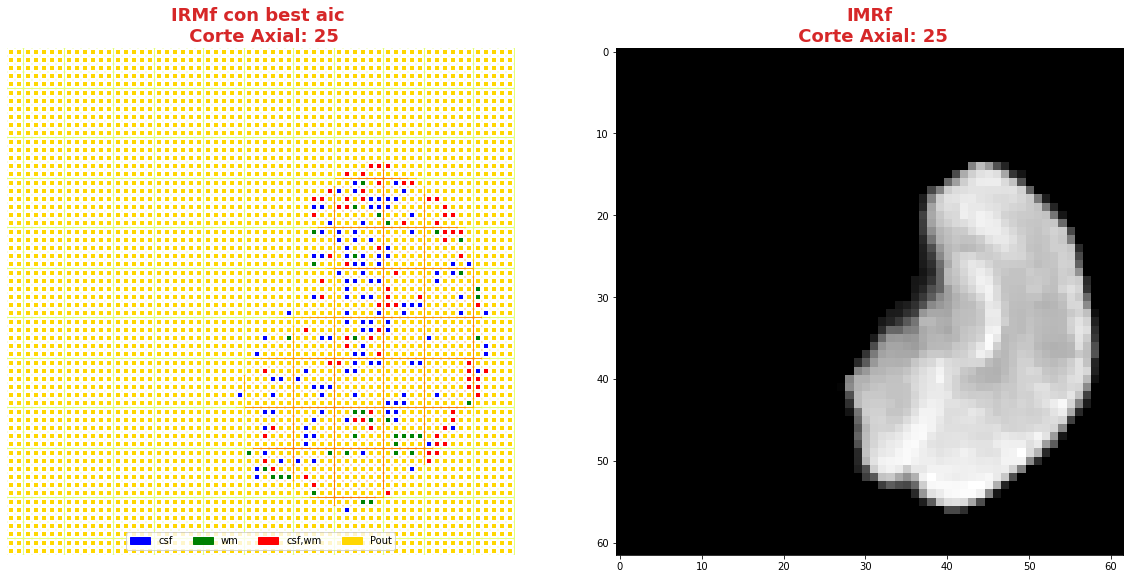

,voxel/serie,z,y,x,MODELO_P
voxel/serie,,,,,
25,25,0,0,25,Pout
69,69,0,1,25,Pout
113,113,0,2,25,Pout
157,157,0,3,25,Pout
201,201,0,4,25,Pout
...,...,...,...,...,...
168941,168941,61,57,25,Pout
168985,168985,61,58,25,Pout
169029,169029,61,59,25,Pout


In [72]:
'''
inputs para la funcion
'''
visual_analis_corte_axial(df_sel=aic_p_voxels,
                          datos_img_fis=datos_func_orig, 
                          vol=40,
                          corte_selec=corte_sagital,
                          df_color=df_color)

## Para los mejores modelos r2 ajustado

In [73]:
analisis_p_r2ajus = analisi_p(df_anali=best_r2_aju, 
                            nivel_signif=0.05)
analisis_p_r2ajus

,serie,MODELO,R2-adj,const,csf,wm,valores_p_regresores,suma_evaluación,MODELO_P
serie,,,,,,,,,
25,25,csf,NaN,NaN,NaN,NaN,"[nan, nan]",2,Pout
69,69,csf,NaN,NaN,NaN,NaN,"[nan, nan]",2,Pout
113,113,csf,NaN,NaN,NaN,NaN,"[nan, nan]",2,Pout
157,157,csf,NaN,NaN,NaN,NaN,"[nan, nan]",2,Pout
201,201,csf,NaN,NaN,NaN,NaN,"[nan, nan]",2,Pout
...,...,...,...,...,...,...,...,...,...
168941,168941,csf,NaN,NaN,NaN,NaN,"[nan, nan]",2,Pout
168985,168985,csf,NaN,NaN,NaN,NaN,"[nan, nan]",2,Pout
169029,169029,csf,NaN,NaN,NaN,NaN,"[nan, nan]",2,Pout


In [74]:
'''
inputs para la función
'''

r2ajus_p_voxels = dataframe_posicion(voxel_posicion= voxels_sel, 
                                   df_anali= analisis_p_r2ajus, 
                                   carac= 'MODELO_P')
r2ajus_p_voxels

,voxel/serie,z,y,x,MODELO_P
voxel/serie,,,,,
25,25,0,0,25,Pout
69,69,0,1,25,Pout
113,113,0,2,25,Pout
157,157,0,3,25,Pout
201,201,0,4,25,Pout
...,...,...,...,...,...
168941,168941,61,57,25,Pout
168985,168985,61,58,25,Pout
169029,169029,61,59,25,Pout


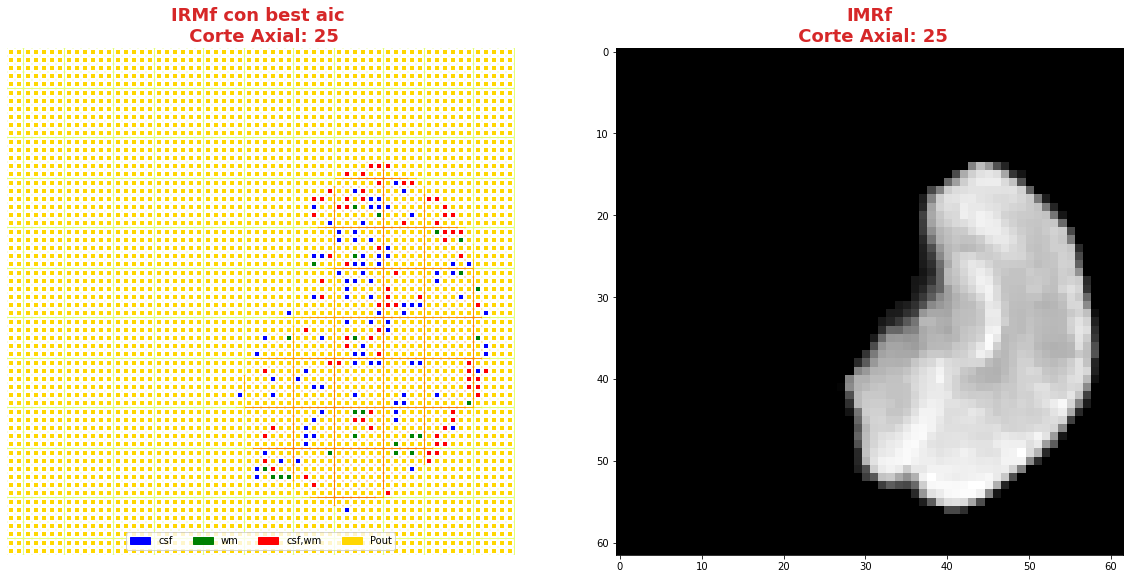

,voxel/serie,z,y,x,MODELO_P
voxel/serie,,,,,
25,25,0,0,25,Pout
69,69,0,1,25,Pout
113,113,0,2,25,Pout
157,157,0,3,25,Pout
201,201,0,4,25,Pout
...,...,...,...,...,...
168941,168941,61,57,25,Pout
168985,168985,61,58,25,Pout
169029,169029,61,59,25,Pout


In [75]:
'''
inputs para la funcion
'''
visual_analis_corte_axial(df_sel=r2ajus_p_voxels,
                          datos_img_fis=datos_func_orig, 
                          vol=40,
                          corte_selec=corte_sagital,
                          df_color=df_color)

# Visualización con las mascaras

In [76]:
def visual_solo_wm(df_sel, datos_img_fis, vol, corte_selec):    
    '''
    Visualizamos
    '''
    vol_img_data = datos_img_fis[:, :, :, vol]
    corte_coro = vol_img_data[:, :, corte_selec]

    font1 = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'}
    font2  = {'fontsize':18, 'fontweight':'bold', 'color':'tab:red'}
    titulo =['IRMf con best aic \n Corte Axial: ' + str(corte_selec), 
             'IMRf\n Corte Axial: ' + str(corte_selec)]

    fig, axes = plt.subplots(1, 2, figsize=(20, 20))

    axes[0].imshow(corte_coro, cmap = 'gray')
    axes[1].imshow(corte_coro , cmap = 'gray')
    
    #Extraemos una lista del indice
    lista_indice = df_sel.index.to_list()

    for i,lis in enumerate(lista_indice):
        k = df_sel['MODELO_P'][lis]
        if k == 'wm':
            colore = 'green'
            le_1 = mpatches.Patch(color=colore, label=k)

            axes[0].scatter(df_sel['y'][lis],df_sel['z'][lis], 
                              marker="s",edgecolor='white', 
                              color=colore,linewidth=2,  s=40)
            axes[0].axis('off')
            
        if k == 'csf,wm':
            colore = 'red'
            le_1 = mpatches.Patch(color=colore, label=k)

            axes[0].scatter(df_sel['y'][lis],df_sel['z'][lis], 
                              marker="s",edgecolor='white', 
                              color=colore,linewidth=2,  s=40)
            axes[0].axis('off')

    for i,title in enumerate(titulo):
        axes[i].set_title(title, fontdict=font2)

    fig.patch.set_facecolor('xkcd:white')
    axes[0].legend(handles=[le_1],loc = 'lower center',ncol=4)
    plt.show()
    
    return df_sel

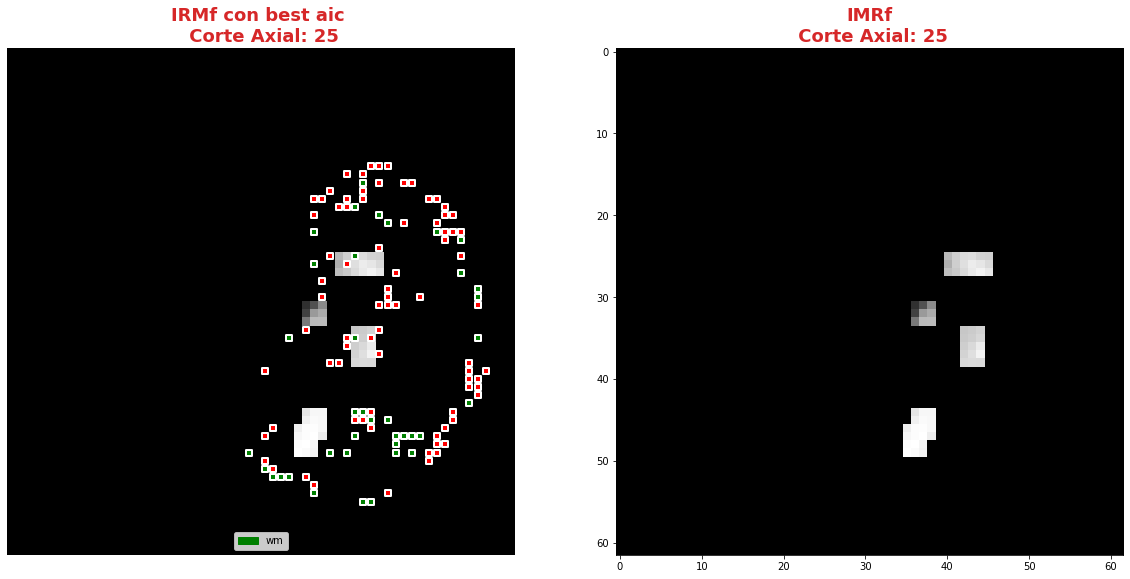

,voxel/serie,z,y,x,MODELO_P
voxel/serie,,,,,
25,25,0,0,25,Pout
69,69,0,1,25,Pout
113,113,0,2,25,Pout
157,157,0,3,25,Pout
201,201,0,4,25,Pout
...,...,...,...,...,...
168941,168941,61,57,25,Pout
168985,168985,61,58,25,Pout
169029,169029,61,59,25,Pout


In [77]:
visual_solo_wm(df_sel=aic_p_voxels, 
                datos_img_fis=datos_img['gm'],
                vol=40, 
                corte_selec=corte_sagital)

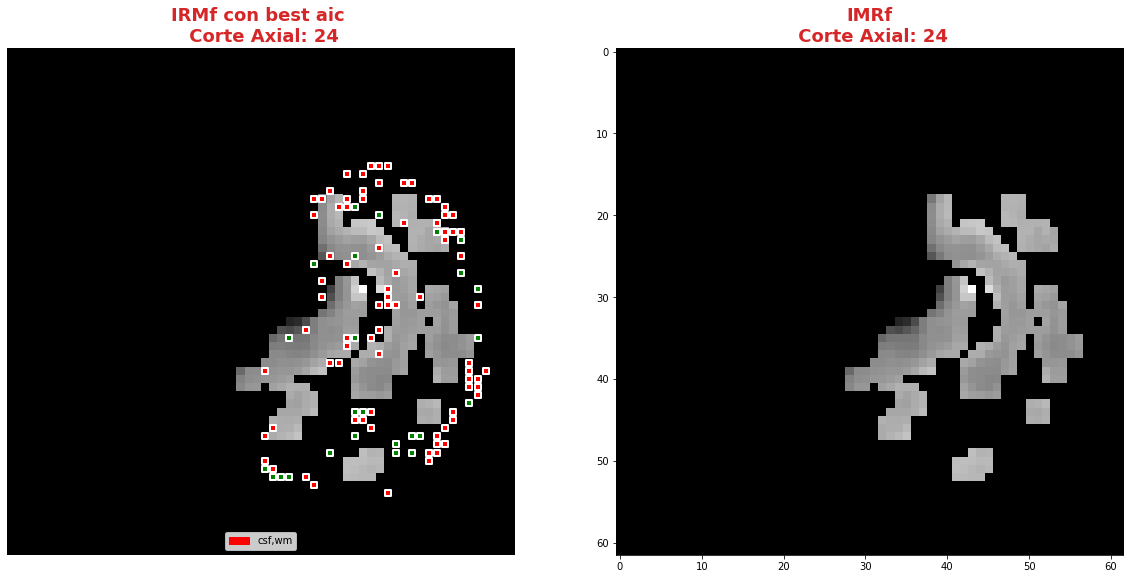

,voxel/serie,z,y,x,MODELO_P
voxel/serie,,,,,
25,25,0,0,25,Pout
69,69,0,1,25,Pout
113,113,0,2,25,Pout
157,157,0,3,25,Pout
201,201,0,4,25,Pout
...,...,...,...,...,...
168941,168941,61,57,25,Pout
168985,168985,61,58,25,Pout
169029,169029,61,59,25,Pout


In [78]:

'''
cargamos imagen funcional
'''

datos_img_fis = datos_img['wm'] 

'''
inputs para la funcion
'''
df_anali_voxels = r2ajus_p_voxels
vol = 40
corte_selec = 24

visual_solo_wm(df_anali_voxels, datos_img_fis, vol, corte_selec)

# Tiempo de ejecución

In [79]:
fin = time.time()
end = time.process_time()
tiempo = fin - inicio
tiempo2 = end - start

print('-----------------------------\n', 
      'tiempo de ejecución\n\n', tiempo, 'seg\n', tiempo/60, ' min\n',      
     '-----------------------------\n')
print('---------------------------------------\n', 
      'tiempo de ejecución del sistema y CPU\n\n', tiempo2, 'seg\n', tiempo2/60, ' min\n',   
     '---------------------------------------\n')

-----------------------------
 tiempo de ejecución

 518.8258280754089 seg
 8.64709713459015  min
 -----------------------------

---------------------------------------
 tiempo de ejecución del sistema y CPU

 512.378441287 seg
 8.539640688116666  min
 ---------------------------------------

